## Формулы

Область значения функции линейной регрессии принадлежит рациональным значениям, т.е.:
$$
y = Xw^{T} \in R
$$
где $X$ - матрица признаков, $w^{T}$ - вектор весов  
Вероятность объекта принадлежать положительному классу принадлежит отрезку от 0 до 1, т.е.:
$$
p_+ \in [0,1]
$$
Чтобы воспользоваться линейной для классификации необходимо привести область значений линейной регрессии к области значений вероятность объекта принадлежать положительному классу
$$
\frac{p_+}{1-p_+} \in [0,+\infty)
$$
Прологарифмируем это отношение
$$
\ln(\frac{p_+}{1-p_+}) \in R
$$
Теперь области значений выражений совпадают и их можно приравнять
$$
\ln(\frac{p_+}{1-p_+}) =  Xw^{T} <=>  (\frac{p_+}{1-p_+}) = e^{(Xw^{T})}
$$
Выразим $p_+$ из полученного уравнения
$$
p_+ = \frac{e^{Xw^{T}}}{1-e^{Xw^{T}}}
$$
Упростим получившуюся дробь
$$
p_+ = \frac{1}{1+e^{-Xw^{T}}} = \sigma(Xw^{T}) \in [0,1]
$$
Мы получили сигмоиду  

Введем понятие Margin: $M = y_{true} * Xw^{T}$, где 
$y_{true}$ вектор истиных меток  

Рассмотрим вычисление вероятности объекта принадлежать определенному классу  
При y = 1: $P(x_i,1|w) = \sigma_w(x_i) = \sigma_w(M_i) $  
При y = -1: $P(x_i,-1|w) = 1 - \sigma_w(x_i) = \sigma_w(-x_i) = \sigma_w(M_i) $  
где $x_i$ вектор признаков i-того объекта, $M_i$ - margin i-того объекта  

Тогда  
$\log(L(w|X,Y)) = \sum_{i = 1}^{n}\log(\sigma_w(M_i)) = \sum_{i = 1}^{n}\log(\sigma_w(1+exp(-M_i))) \rightarrow min$  

In [1]:
from torch.nn import Linear
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
digits = load_digits(n_class=2)

Заменим метки классов (0 заменим на -1) 

In [3]:
digits.target = np.where(digits.target == 0, -1,digits.target)

Разделим данные на тренировочную и тестовую выборку

In [4]:
train_X,test_X,train_Y,test_Y = train_test_split(digits.data,
                                                digits.target,
                                                test_size = 0.33,
                                                random_state = 42)

train_X_torch = torch.tensor(train_X, dtype = torch.float32)
train_Y_torch = torch.tensor(train_Y, dtype = torch.float32)
test_X_torch = torch.tensor(test_X, dtype = torch.float32)
test_Y_torch = torch.tensor(test_Y, dtype = torch.float32)

Реализуем класс линейного классификатора

In [5]:
class LinearClassifier():
    def __init__(self,n_features,max_iter = 1000):
        self.n_features = n_features
        self.max_iter = max_iter
        self.model = torch.nn.Sequential()
        self.model.add_module('first', torch.nn.Linear(self.n_features,1))
        self.model.add_module('second', torch.nn.Sigmoid())
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr = 1e-3)
    
    def fit(self,design_matrix,target):
        history = []
        for i in range(self.max_iter):
            #создание небольших обучающих выборок
            sampling  = np.random.randint(0,design_matrix.shape[1],25)
            part_design_matrix = design_matrix[sampling]
            part_target_vector = target[sampling]
            
            #получим вектор весов и сдвиг из линейной модели
            self.wight = torch.tensor(self.model.state_dict()['first.weight'],
                                      requires_grad=True,
                                      dtype = torch.float32
                                     )
            self.bias = torch.tensor(self.model.state_dict()['first.bias'],
                                     requires_grad=True,
                                     dtype = torch.float32
                                    )
            # Посчитаем ошибку 
            loss = torch.mean(
               torch.log(1+torch.exp(-(
                    part_target_vector*(
                        part_design_matrix.matmul(self.wight.transpose(0,1)) + self.bias)))))



            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            history.append(loss.data.numpy())
            if i % 100 == 0:
                print('loss{}:{}'.format(i, np.mean(history[-100:])))

    
    def predict(self,design_matrix):
        return self.model(design_matrix)[:,0]

            

In [6]:
torch_classifier = LinearClassifier(64)

In [7]:
torch_classifier.fit(train_X_torch,train_Y_torch)

loss0:0.8456318378448486
loss100:0.9093196988105774
loss200:0.8922378420829773
loss300:0.9087621569633484
loss400:0.8912403583526611
loss500:0.8980517387390137
loss600:0.914628803730011
loss700:0.8879900574684143
loss800:0.8896862268447876
loss900:0.9076845645904541


Предскажем метки на тестовой выборке

In [8]:
final_pred = torch_classifier.predict(test_X_torch)

Напишем функцию, которая на основании ROC-кривой подберет наилучший порог, при котором мы получим максимальную точность 

In [9]:
def best_threshold(target_vector,predictions):
    # Первичное получение данных метрики ROC-кривой
    fpr, tpr, thresholds = roc_curve(np.array(target_vector), predictions.data.numpy(), pos_label=1)
    best_accuracy = 0
    best_threshold = -1
    
    #Найдем площадь под кривой
    auc_value = round(auc(fpr,tpr),2)
    
    #Если площадь будеть меньше 0.5, это означает, что нужно нужно вычесть каждую вероятность из 1
    if auc_value < 0.5:
        predictions = 1 - predictions
        fpr, tpr, thresholds = roc_curve(np.array(target_vector), predictions.data.numpy(), pos_label=1)
        auc_value = round(auc(fpr,tpr),2)
        
    # переберем все пороги в поисках наилучшей точности
    for threshold in thresholds:
        pre_marker = np.array(predictions > threshold)
        pre_marker = np.where(pre_marker == False, -1,pre_marker)
        pre_marker = np.where(pre_marker == True, 1,pre_marker)
        accuracy = accuracy_score(target_vector,pre_marker)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
            
    #Построим ROC-кривую
    fig,ax = plt.subplots(figsize= (10,5))
    ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label = 'BaseLine',ls = '--')
    ax.plot(fpr,
            tpr,
            label = f"Logistic Regression (area = {auc_value}, best_accuracy = {best_accuracy})")
    ax.legend()
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    
    
    return best_threshold,predictions
    

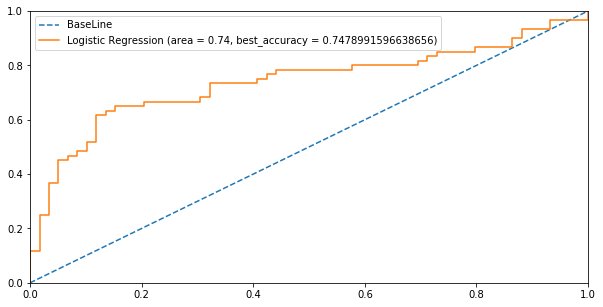

In [10]:
final_threshold,final_pred = best_threshold(test_Y, final_pred)

In [11]:
final_pred = np.array(final_pred > final_threshold)

In [12]:
final_pred = np.where(final_pred == False, -1,final_pred)
final_pred = np.where(final_pred == True, 1,final_pred)

## Итог

In [13]:
print("Final accuracy:", accuracy_score(test_Y,final_pred))

Final accuracy: 0.7478991596638656
